# Dependencies

In [88]:
import pandas as pd
import cleantext
import csv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Data cleaning and structuring

### Loading the data

In [89]:
df = pd.read_csv('data_test.csv')
print(df['content'].head(5))

0    Sometimes the power of Christmas will make you...
1    AWAKENING OF 12 STRANDS of DNA – “Reconnecting...
2    Never Hike Alone: A Friday the 13th Fan Film U...
3    When a rare shark was caught, scientists were ...
4    Donald Trump has the unnerving ability to abil...
Name: content, dtype: object


### cleaning med clean

In [90]:
df['content'] = df['content'].apply(lambda x: cleantext.clean(text=x))
print(df['content'].head(5))

0    sometim power christma make wild wonder thing ...
1    awaken strand dna – “reconnect you” movi reade...
2    never hike alon friday th fan film usa min fan...
3    rare shark caught scientist left blunder answe...
4    donald trump unnerv abil abil creat realiti co...
Name: content, dtype: object


### cleaning med clean_words

In [91]:
df['content'] = df['content'].apply(lambda x: cleantext.clean_words(
    text=x,
    clean_all=True,
    extra_spaces=True,
    stemming=True,
    stopwords=True,
    stp_lang='english',
))

print(df['content'].head(5))

0    [sometim, power, christma, make, wild, wonder,...
1    [awaken, strand, dna, –, “reconnect, you”, mov...
2    [never, hike, alon, friday, th, fan, film, usa...
3    [rare, shark, caught, scientist, left, blunder...
4    [donald, trump, unnerv, abil, abil, creat, rea...
Name: content, dtype: object


### Export

In [92]:
df.to_csv('data_cleaned.csv')

# Categorization and splitting

In [93]:
temp = []  # Temporary list to store filtered rows
categories = set()  # Set to track unique categories
convert = {  # Dictionary to map categories to standardized labels
    '': "skip", 'conspiracy': 'fake', 'satire': 'fake', 'reliable': 'reliable',
    'unreliable': 'fake', 'junksci': 'fake', 'unknown': 'skip',
    'political': 'reliable', 'fake': 'fake', 'hate': 'fake',
    'clickbait': 'reliable', 'bias': 'reliable', 'rumor': 'fake'
}

fakeCount = 0  # Counter for fake news articles
realCount = 0  # Counter for reliable news articles

with open("data_cleaned.csv", "r") as src:  # Open CSV file for reading
    reader = csv.reader(src)  # Create a CSV reader object
    header = next(reader)  # Read and discard the header row
    
    for row in reader:  
        content = row[4]  # Extract category from the fourth column
        categories.add(content)  # Store the unique category
        
        row[4] = convert[row[4]]  # Convert category using the dictionary
        
        if row[4] == "fake":
            fakeCount += 1  # Increment fake count
        elif row[4] == "reliable":
            realCount += 1  # Increment real count
        
        if row[4] != "skip":  # Skip unwanted categories
            temp.append(row)  # Append valid rows to the list

# Create a DataFrame from the filtered list, keeping the original column names
df = pd.DataFrame(temp, columns=header)

# Save the processed data to a new CSV file without renaming columns
df.to_csv('data_cleaned_fr.csv', index=False)

# Print the ratio of fake vs. real news articles and number of articles
print(f"Ratio of fakes: {fakeCount/(fakeCount+realCount)}")
print(f"Ratio of real: {realCount/(fakeCount+realCount)}")
print(f"Number of articles left: {len(temp)}")

Ratio of fakes: 0.8577586206896551
Ratio of real: 0.14224137931034483
Number of articles left: 232


In [94]:
train_data = pd.read_csv("data_cleaned_fr.csv")

### Splitting

In [95]:
X = train_data['content']
y = train_data['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Vectorization

In [96]:
vectorizer = CountVectorizer(stop_words='english', max_features=50000)  
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

### Smote

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

# Training and evaluation

### Model training

In [98]:
classifier = MultinomialNB()
classifier.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

### Evaluation

In [99]:
y_pred = classifier.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8723404255319149
              precision    recall  f1-score   support

        fake       0.87      1.00      0.93        41
    reliable       0.00      0.00      0.00         6

    accuracy                           0.87        47
   macro avg       0.44      0.50      0.47        47
weighted avg       0.76      0.87      0.81        47



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


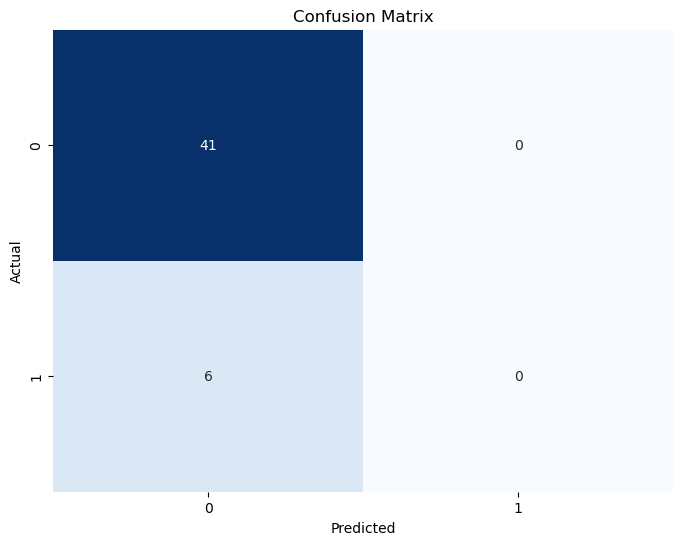

In [100]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()